In [229]:
import jax.numpy as jnp
import jax.random as jrandom

import matplotlib.pyplot as plt
import pandas as pd
from jax import jit, grad, jacfwd, jacrev

import itertools

from scipy.stats import linregress

from tqdm import tqdm
import pickle

import numpy as np

from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go



%matplotlib inline
plt.rcParams['figure.figsize'] = [6,6]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})

In [230]:
def loss_getter(dim, N, H, sig):
    def helper(X):

        S = X.reshape(N, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        
        return 1/2 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term)

    return helper


def get_a(D_min, sum_sqrt, dim, sig):
    disc = sig**4 * (sum_sqrt**2) * (8 * (dim + 1) * D_min + sum_sqrt**2)
    return 1/jnp.sqrt(dim * D_min) * jnp.sqrt(jnp.sqrt(disc) + 2 * (dim + 1) * D_min * sig**2 + sig**2 * sum_sqrt**2)

def get_lambda_max(D_min, sum_sqrt, dim, sig):
    disc = sig**4 * (sum_sqrt**2) * (8 * (dim + 1) * D_min + sum_sqrt**2)
    numerator = jnp.sqrt(disc) + 4 * (dim + 1) * D_min * sig**2 + sig**2 * sum_sqrt**2
    denom = D_min**(1.5) * 2 * jnp.sqrt(1/dim) * jnp.sqrt(jnp.sqrt(disc) + 2 * (dim + 1) * D_min * sig**2 + sig**2 * sum_sqrt**2)
    return numerator/denom

def get_full_sing_vals(D, dim, sig):
    D_diag = jnp.abs(jnp.diag(D))
    max_row = jnp.argmin(D_diag)
    sum_sqrt = jnp.sum(jnp.sqrt(D_diag)) - jnp.sqrt(D_diag[max_row])
    lmbda_max = get_lambda_max(jnp.min(D_diag), sum_sqrt, dim, sig)
    a = get_a(jnp.min(D_diag), sum_sqrt, dim, sig)
    lmbda = sig*np.array(jnp.sqrt(lmbda_max / (a * D_diag)))
    lmbda[max_row] = lmbda_max
    lmbda = jnp.array(lmbda)
    sing_val = jnp.sqrt(lmbda)
    return sing_val

We will first explore in 3D. We know that we have to satisfy the conditions 
$$
U_{i, 1} = \frac{1}{\sqrt{d}} 
$$

$$
\sum_{j} U_{i, j}^2 c_j = \frac{1}{d} \sum_{j} c_j.
$$

The first condition contrains us to a unit circle in 3D. 


Let us write $s_j x_j = U_{i, j}^2$ with $\sum_{j} x_j = 1$ which then leads to the condition 
$$
\sum_{j} s_j x_j c_j = \bar{c}.
$$

We have letting $x_1 = 1$ and $x_i = 0$ for $i \neq 1$
$$
    s_1  = \frac{\bar{c}}{c_1}
$$
which then leads to 
$$
    x_1 = \frac{1}{s_1 d} = \frac{c_1}{\bar{c} d}
$$
since we constrain $U_{j, 1} = \frac{1}{\sqrt{d}}$.



Since we know that for $j = 1$ $s_j x_j = \frac{1}{d}$ we have
$$
    \sum_{j = 2}^d s_j x_j c_j = \bar{c} - \frac{c_1}{d}
$$

which when letting all $j \neq k$ and $j \neq 1$ be $x_j = 0$ leads to 


$$
    s_k (1 - \frac{1}{d}) c_k = \bar{c} - \frac{c_1}{d}
$$

$$
    s_k = \bar{c}_{1} \frac{1}{(1 - \frac{1}{d}) c_k}.
$$


Looking at it in another way we see that the constraint $U_{j, 1} = \frac{1}{\sqrt{d}}$ implies that 
$$
    \sum_{j = 2}^d U_{i, j}^2 = 1 - \frac{1}{d} 
$$
which implies that the candidate vectors lie on a sphere of radius $\sqrt{\frac{d - 1}{d}}$. Two unit vectors are $\sqrt{2}$ distance aparat iff they are orthogonal. 

The next condition gives that 
$$
    \sum_{j = 2}^d U_{i, j}^2 c_j = \bar{c} - \frac{c_1}{d}
$$

which is an ellipsoid with axis $\frac{1}{\sqrt{c_j}}$. 

Hence, the condition becomes that we want to find $d$ equidistant points on the intersection of the $d - 1$ dimensional sphere and ellipsoid which have distance $\sqrt{2}$ to each other. 

Let us rescale the sphere and ellipsoid by $\sqrt{\frac{d}{d-1}}$ (i.e. change of variables of $u_{j+1} = \sqrt{\frac{d-1}{d}}v_j$)  which then makes the sphere $\sum_{j = 1}^{d - 1} v_j^2$ a unit sphere and the ellipsoid is now equal to $\sum_{j = 1}^{d-1} v_j^2 c_j = \frac{1}{d-1} \sum_{j = 1}^{d - 1} c_j$. The distance that points have to be apart now for them to be orthogonal is then
$$
    \Vert u_1 - u_2 \Vert = \sqrt{2} \\
    \sqrt{\frac{d-1}{d}} \Vert v_1 - v_2 \Vert = \sqrt{2} \\
    \Vert v_1 - v_2 \Vert = \sqrt{2} \sqrt{\frac{d}{d-1}}.
$$


Put even more nicely. Given an ellipsoid with $\sum_{j = 1}^{d-1} v_j^2 c_j = \frac{1}{d-1} \sum_{j = 1}^{d - 1} c_j$ we want to find the simplex (unit vectors) with equidistant points $\sqrt{2} \sqrt{\frac{d}{d-1}}$ which fits into the ellipsoid. 

In [106]:
def generate_circle(dim, num_samples, jrandom_key):
    unit_circle = jrandom.normal(jrandom_key, shape=(num_samples, dim - 1))
    unit_circle = unit_circle / (np.linalg.norm(unit_circle, axis=1).reshape(-1, 1)) * jnp.sqrt(1 - 1/dim)
    return unit_circle

def generate_sqrt_hp(c, dim, num_samples, jrandom_key):
    cbar = jnp.mean(c)
    cbar_sub = cbar - c[0]/dim
    
    dist_hp = jrandom.uniform(subkey, minval=0, maxval=1, shape=(num_samples_hp, dim-1))
    dist_hp = dist_hp / jnp.sum(dist_hp, axis=1).reshape(-1, 1) * (dim - 1)/dim
    dist_hp = dim/(dim - 1) * cbar_sub * dist_hp @ jnp.linalg.inv(jnp.diag(c[1:]))

    # ++++ Test ++++
    # u_squared = jnp.concatenate([1/dim * jnp.ones(shape=(num_samples, 1)), dist_hp], axis=1)
    # print(u_squared @ c)
    # print(cbar)
    # ++++ End ++++

    dist_hp_sqrt = jnp.sqrt(dist_hp)

    # we now reflect the points across all axis
    res = []
    for p in itertools.product([-1, 1], repeat=dim-1):
        res.append(dist_hp_sqrt * jnp.array(p))
    dist_hp_sqrt = jnp.concatenate(res, axis=0)
    
    return dist_hp_sqrt


def generate_ellipse(c, dim, num_samples, jrandom_key):
    cbar = jnp.mean(c)
    cbar_sub = cbar - c[0]/dim
    circ = generate_circle(dim, num_samples, jrandom_key)
    ellipsoid = jnp.sqrt(dim/(dim - 1) * cbar_sub) * circ @ jnp.sqrt(jnp.linalg.inv(jnp.diag(c[1:])))
    return ellipsoid


    
    

(-1, 1)

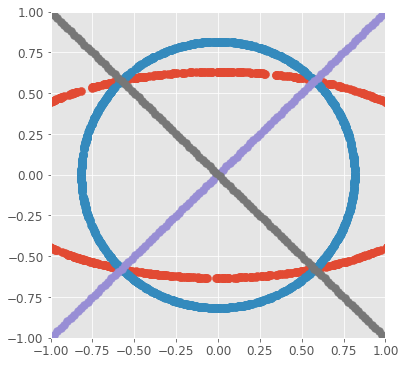

In [112]:
dim = 3
num_samples = 1000

c = jnp.array([1, 20, 100]) # smallest value is first
cbar = jnp.mean(c)
cbar_sub = cbar - c[0]/dim

jrandom_key = jrandom.PRNGKey(10)
jrandom_key, subkey = jrandom.split(jrandom_key)
unit_circle = generate_circle(dim, num_samples, subkey)

jrandom_key, subkey = jrandom.split(jrandom_key)
ellipsoid = generate_ellipse(c, dim, num_samples, subkey)


plt.scatter(ellipsoid[:, 0], ellipsoid[:, 1])
plt.scatter(unit_circle[:,0], unit_circle[:,1])

plt.scatter(jnp.linspace(-1, 1, 100), jnp.linspace(-1, 1, 100))
plt.scatter(-jnp.linspace(-1, 1, 100), jnp.linspace(-1, 1, 100))



plt.xlim(-1, 1)
plt.ylim(-1, 1)


In [115]:
dim = 4
num_samples

c = jnp.array([1, 10, 20, 30]) # smallest value is first

jrandom_key = jrandom.PRNGKey(10)
jrandom_key, subkey = jrandom.split(jrandom_key)
unit_circle = generate_circle(dim, num_samples, subkey)

jrandom_key, subkey = jrandom.split(jrandom_key)
ellipsoid = generate_ellipse(c, dim, num_samples, subkey)    
    

simplex_vecs = jnp.array([[1, 1, 1], [-1, 1, -1], [-1, -1, 1], [1, -1, -1]])
simplex = jnp.array([[simplex_vecs[i] * alpha for alpha in jnp.linspace(0, 1.2, 100)] for i in range(4)])

fig = go.Figure(data=[go.Scatter3d(x=ellipsoid[:, 0], y=ellipsoid[:, 1], z=ellipsoid[:, 2],
                                   mode='markers'), go.Scatter3d(x=unit_circle[:, 0], y=unit_circle[:, 1], z=unit_circle[:, 2],
                                   mode='markers'),
                     go.Scatter3d(x=simplex[0, :, 0], y=simplex[0, :, 1], z=simplex[0, :, 2],
                                   mode='markers'),
                     go.Scatter3d(x=simplex[1, :, 0], y=simplex[1, :, 1], z=simplex[1, :, 2],
                                   mode='markers'),
                     go.Scatter3d(x=simplex[2, :, 0], y=simplex[2, :, 1], z=simplex[2, :, 2],
                                   mode='markers'),
                     go.Scatter3d(x=simplex[3, :, 0], y=simplex[3, :, 1], z=simplex[3, :, 2],
                                   mode='markers')])
fig.show()


#  [1, 1, 1], [-1, 1, -1], [-1, -1, 1], [1, -1, -1]


In [ ]:
dim = 4
num_samples

c = jnp.array([1, 10, 20, 30]) # smallest value is first

jrandom_key = jrandom.PRNGKey(10)
jrandom_key, subkey = jrandom.split(jrandom_key)
unit_circle = generate_circle(dim, num_samples, subkey)

jrandom_key, subkey = jrandom.split(jrandom_key)
ellipsoid = generate_ellipse(c, dim, num_samples, subkey)    
    
    

fig = go.Figure(data=[go.Surface(x=ellipsoid[:, 0], y=ellipsoid[:, 1], z=ellipsoid[:, 2],
                                   ), go.Surface(x=unit_circle[:, 0], y=unit_circle[:, 1], z=unit_circle[:, 2],
                                   )])
fig.show()



To generate the regular simplex which is inscribed in the unit hypersphere we choose for $1 \leq i \neq d$ 

$$
    \sqrt{1 + \frac{1}{d}} e_i - \frac{1}{d^{3/2}} (\sqrt{d + 1} \pm 1) * \mathbf{1} 
$$

and for $i = d+1$
$$
    \pm \frac{1}{\sqrt{d}} \mathbf{1}.
$$

In [231]:
def generate_regular_simplex(dim):
    res = []
    I = np.eye(dim)
    for i in range(dim):
        res.append(jnp.sqrt(1 + 1/dim) * I[i] - 1/pow(dim, 3/2) *(np.sqrt(dim + 1) + 1) * np.ones(dim))
        
    res.append(1/np.sqrt(dim) * np.ones(dim))
    
    return jnp.array(res).T

Recall that the ellipsoid is given by $\sum_{j = 1}^{d-1} v_j^2 c_j = \frac{1}{d-1} \sum_{j = 1}^{d - 1} c_j$. Which we can also write as 
$$
    v^T diag(c) v = \bar{c}
$$

In [232]:
def orthog_linesearch(l, c1, c2):

    def helper(X, search_direction, A):
        f0 = l(X)
        g_tau_0 = -1/2 * jnp.linalg.norm(A, "fro")**2
        
        def armijo_rule(alpha):
            return (l(search_direction(alpha)) > f0 + c1*alpha*g_tau_0) # and alpha > 0.001
        
        def armijo_update(alpha):
            return c2*alpha
            
        alpha = 1
        while armijo_rule(alpha):
            alpha = armijo_update(alpha)


        return alpha

    return helper


def optimize_W(c, num_iter, x_init=None):
    """Constraint is U.c = \bar{c} 1 and U.U^T = I"""
    
    dim = len(c)
    
    V = generate_regular_simplex(dim)
    
    # init X
    if x_init is None:
        X = jnp.eye(dim)
    else:
        X = x_init
    I = jnp.eye(dim)
    
    X = X.flatten()

    
    def l(U):
        U_matrix = U.reshape(dim, dim)
        return jnp.linalg.norm(jnp.diag(V.T @ U_matrix.T @ jnp.diag(c) @ U_matrix @ V) - jnp.ones(dim + 1) * jnp.mean(c)) 
    
    
    g_l = grad(l)
    linesearch = orthog_linesearch(l, c1=0.1, c2=0.9)


    eps = 1e-4
    
    l_hist = []
    for _ in tqdm(range(num_iter)):

        num_iter -= 1
        
        G = g_l(X).reshape(dim, dim)
        l_hist.append(l(X))
#         print(jnp.linalg.norm(G))
        
        if jnp.linalg.norm(G) < eps:
            break
        
        A = G @ X.reshape(dim, dim).T - X.reshape(dim, dim) @ G.T
                
        Y = lambda tau: jnp.linalg.inv(I + tau/2 * A) @ (I - tau/2 * A) @ X.reshape(dim, dim)
        
        alpha = linesearch(X, Y, A)
#         print(alpha)
        
        X = Y(alpha)
        
        
    return X, l_hist
        
    


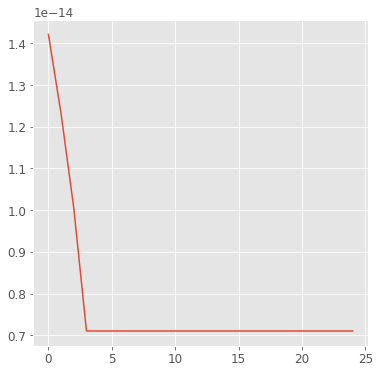

In [182]:
c = jnp.array([1, 2, 100])
dim = c.shape[0]

# W, l_hist = optimize_W(c, 25, x_init=None) 

plt.plot(l_hist)

We will convert back here. First we convert to $u$. Recall that $u_{j+1} = \sqrt{\frac{d-1}{d}}v_j$. Given the unitary matrix we found above (W) we have $u_{j + 1} = \sqrt{\frac{d-1}{d}} (W v)_j$.


In [233]:
def convert_to_U(W):
    dim = W.shape[0] + 1
    V = generate_regular_simplex(dim - 1)
    tmp_U = (jnp.sqrt((dim - 1)/dim) * W @ V)
    U = jnp.concatenate([jnp.ones(shape=(1, dim))/jnp.sqrt(dim), tmp_U])
    return U

convert_to_U(W)

DeviceArray([[ 0.14142136,  0.14142136,  0.14142136, ...,  0.14142136,
               0.14142136,  0.14142136],
             [-0.03596908,  0.03433448, -0.05979171, ..., -0.05532449,
              -0.05398499, -0.06318702],
             [ 0.06674581,  0.03997683, -0.13504654, ...,  0.0376329 ,
              -0.01680263, -0.01134191],
             ...,
             [ 0.11038884,  0.1748763 , -0.14160408, ..., -0.17441459,
               0.08113567,  0.05009682],
             [-0.05288246,  0.09366422, -0.16860965, ...,  0.17762474,
              -0.30512919,  0.00851489],
             [-0.11835135, -0.13027203, -0.05514155, ..., -0.20171282,
               0.12022487,  0.17235326]], dtype=float64)

In [234]:
def construct_c(sing_vals, D):
    return sing_vals**2 * jnp.diag(D)

### Here we test the results. 
We generate some diagonal matrix for the Hessian. Find the singular values. Construct the C. Find the best W. And then check the gradient/loss of the MSE. 

In [252]:
dim = 50

D = jnp.diag(jnp.array([1, 2, 3, 4, 5, 1000]))# jnp.diag(jnp.linspace(1, 100, dim)) # jnp.diag(jnp.array([1, 2, 2, 4, 40, 100, 600, 1000])) # sorted in increasing order
dim = D.shape[0]
sig = 0.1
sing_vals = get_full_sing_vals(D, dim, sig)

c = construct_c(sing_vals, D)

l = loss_getter(dim, dim, D, sig)
g_l = grad(l)

100%|██████████| 25/25 [00:05<00:00,  4.56it/s]


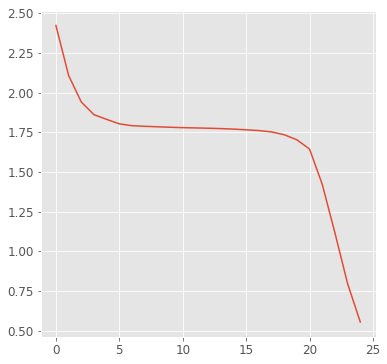

In [256]:
W, l_hist = optimize_W(c[1:], 25, x_init=None) 

plt.plot(l_hist)

In [257]:
U = convert_to_U(W)
S = jnp.diag(sing_vals) @ U

In [258]:
print(l(S.T.flatten()))
print(g_l(S.T.flatten()))

5.597447040160587
[-5.54391273e-02 -3.52762581e+00  6.14130222e+00  7.20493443e+00
  4.69422222e+00  3.48566860e+02 -4.99405654e-02  3.76060240e+00
 -4.70979095e+00  6.01604100e+00  3.79204341e+00  3.18951111e+02
 -4.64438742e-02  3.23895291e+00  4.44059920e+00 -6.13972447e+00
  3.34414204e+00  2.95548321e+02  6.92442230e-02 -4.49247090e+00
 -5.95378562e+00 -6.61434958e+00  7.84352000e+00  4.51053220e+02
  1.27467828e-02 -1.12786456e+00 -1.38084711e+00 -1.47195635e+00
 -3.96240190e+00  6.47392658e+01  6.98325610e-02  2.76310244e+00
  3.10815252e+00  3.61796887e+00 -8.73997000e+00  4.76288085e+02]


In [250]:
S

DeviceArray([[ 1.82878317,  1.82878317,  1.82878317, ...,  1.82878317,
               1.82878317,  1.82878317],
             [-0.01929512,  0.01841826, -0.03207444, ..., -0.02967806,
              -0.0289595 , -0.03389581],
             [ 0.03150165,  0.01886765, -0.06373717, ...,  0.01776139,
              -0.00793025, -0.00535298],
             ...,
             [ 0.02494239,  0.03951335, -0.03199548, ..., -0.03940903,
               0.01833263,  0.01131939],
             [-0.01188673,  0.0210535 , -0.03789946, ...,  0.03992584,
              -0.06858583,  0.00191395],
             [-0.02646719, -0.02913303, -0.01233143, ..., -0.0451095 ,
               0.02688617,  0.03854376]], dtype=float64)